In [117]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from tensorflow_probability.python.mcmc.internal import slice_sampler_utils as ssu

import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt

from collections import namedtuple

## Gram-Schmidt for conjugate directions

$$\begin{align}
v_i = u_i + \sum_{j = 1}^{i - 1} \beta_{ij} v_j.
\end{align}$$

where $v_0 = u_0$ and $\beta_{ij}$ are appropriately chosen constants such that $d_i A d_j = 0$ whenever $i \neq j$

$$\begin{align}
\beta_{ij} = - \frac{u_i^\top A v_j}{v_j^\top A v_j}.
\end{align}$$

In [276]:
def quadratic_form(x, mean, cov):
    
    diff = x - mean
    prec_diff = tf.linalg.solve(cov, diff)
    quad = - 0.5 * tf.reduce_sum(diff * prec_diff, axis=0)
    
    return quad

def quad_log_prob(x, mean, cov):
    
    with tf.GradientTape() as tape:
        
        tape.watch(x)
        
        log_prob = quadratic_form(x, mean, cov)
        
    gradients = tape.gradient(log_prob, x)
    
    return log_prob, gradients


def autocorrelation(x):
    return correlate(x, x) - np.mean(x) ** 2

In [344]:
class cgcs_kernel(tfp.mcmc.TransitionKernel):
    
    def __init__(self, log_prob, reset_every):
        
        super().__init__()
        
        self.log_prob = log_prob
        self.epsilon = 1e-3
        self.reset_every = reset_every
        
    
    def is_calibrated(self):
        return True
    
    
    def one_step(self, current_state, previous_kernel_results, seed=None):
        
        x = current_state
        D = previous_kernel_results[0]
        
        d = self.new_conjugate_direction(x, D)
        d = d / tf.reduce_sum(d ** 2, axis=0, keepdims=True) ** 0.5
        cond_log_prob = self.cond_log_prob(x, d)
        
        result = ssu.slice_sampler_one_dim(cond_log_prob,
                                           x_initial=tf.zeros(shape=()),
                                           max_doublings=5,
                                           step_size=1.0*tf.ones(shape=()))
            
        stepsize, _, _, _, _ = result
        x = x + stepsize * d
        
        if D.shape[1] == self.reset_every:
            D = D[:, 1:]
            
        D = tf.concat([D, d], axis=-1)
        
        return x, [D]
    
    def bootstrap_results(self, initial_state):
        return [tf.zeros(shape=(initial_state.shape[0], 0))]
    
    
    def new_conjugate_direction(self, x, D):
        
        _, dl = self.log_prob(x)
        
        if D.shape[1] == 0:
            return dl
        
        else:
            # Get hessian-gradient products at x, compute conjugate direction
            AD = self.grad_hessian_products(x, D)
            d = self.conjugate_by_gram_schmidt(dl, D, AD)
        
            return d
    
    
    def conjugate_by_gram_schmidt(self, d, D, AD):
        
        DTAD = tf.matmul(D, AD, transpose_a=True)
        DTAd = tf.matmul(AD, d, transpose_a=True)
        a = - tf.linalg.solve(DTAD, DTAd)
        
        d = d + np.matmul(D, a)
        
        return d
    
        
    def grad_hessian_products(self, x, D):
        
        K = D.shape[-1]
        
        X = tf.tile(x, multiples=[1, K])
        
        _, dl_pos = self.log_prob(X + self.epsilon * D)
        _, dl_neg = self.log_prob(X - self.epsilon * D)
        
        AD = (dl_pos - dl_neg) / (2 * self.epsilon)
        
        return AD
    
    def cond_log_prob(self, x, d):
        return lambda a : self.log_prob(x + a * d)[0]

tf.Tensor(-0.76974076, shape=(), dtype=float32) tf.Tensor(0.17650232, shape=(), dtype=float32)


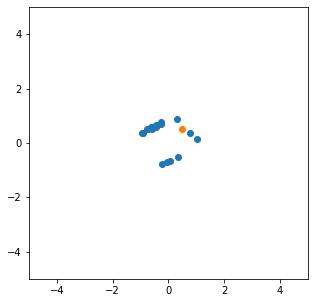

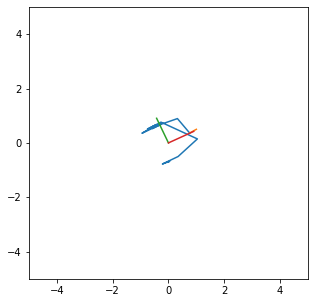

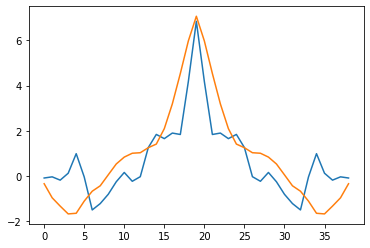

In [342]:
num_results = 20
init_state = tf.transpose(tf.convert_to_tensor([[1.0, 0.5]]))
mean = tf.zeros((2, 1))
cov = tf.convert_to_tensor([[1.0, 0.3],
                            [0.3, 0.5]])

log_prob = lambda x : quad_log_prob(x, mean, cov)

states = tfp.mcmc.sample_chain(num_results=num_results,
                               current_state=init_state,
                               kernel=cgcs_kernel(log_prob, reset_every=1),
                               num_burnin_steps=0,
                               num_steps_between_results=0,
                               trace_fn=None)

log_probs = tf.convert_to_tensor([log_prob(state)[0] for state in states])
print(tf.reduce_mean(log_probs), tf.reduce_mean(log_probs ** 2) ** 0.5 / states.shape[0] ** 0.5)

# diffs = tf.transpose(states[1:, :, 0] - states[:-1, :, 0])
# inner_prod = tf.matmul(diffs, tf.linalg.solve(cov, diffs), transpose_a=True)
# print(inner_prod)

states_ = np.array(states)[:, :, 0]
eigval, eigvec = tf.linalg.eig(cov)
eigvec = np.real(np.array(eigvec))

plt.figure(figsize=(5, 5))
plt.scatter(states_[:, 0], states_[:, 1])
init_state = np.array(init_state)
plt.scatter([init_state[1, 0]], [init_state[1, 0]])

plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(states_[:, 0], states_[:, 1])
plt.plot([states_[0, 0], init_state[0]], [states_[0, 1], init_state[1]])
plt.plot([0, eigvec[0, 0]], [0, eigvec[0, 1]])
plt.plot([0, eigvec[1, 0]], [0, eigvec[1, 1]])

plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.show()

corr1 = correlate(states_[:, 0], states_[:, 0])
corr1 = corr1 - np.mean(states_[:, 0]) ** 2
plt.plot(corr1)
corr2 = correlate(states_[:, 1], states_[:, 1])
corr2 = corr2 - np.mean(states_[:, 1]) ** 2
plt.plot(corr2)
plt.show()

tf.Tensor(-1.3400605, shape=(), dtype=float32) tf.Tensor(0.34521085, shape=(), dtype=float32)


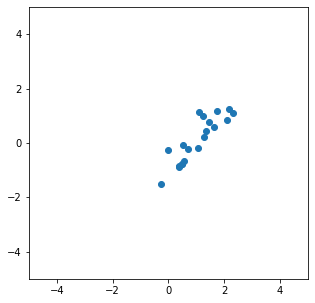

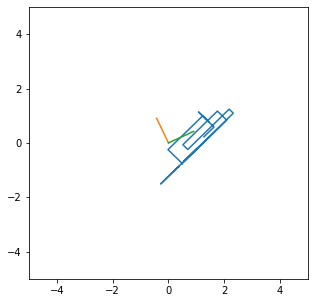

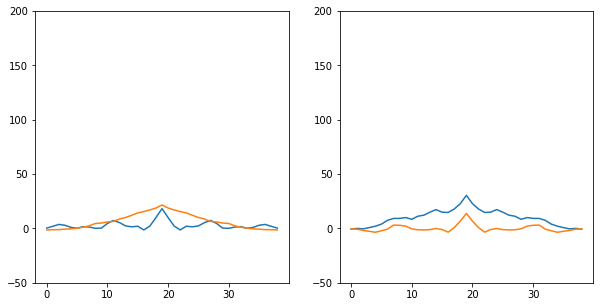

In [280]:
num_results = 20
init_state = tf.transpose(tf.convert_to_tensor([[1.0, 0.5]]))
mean = tf.zeros((2, 1))
cov = tf.convert_to_tensor([[1.0, 0.3],
                            [0.3, 0.5]])

log_prob = lambda x : quadratic_form(x, mean, cov)

states = tfp.mcmc.sample_chain(num_results=num_results,
                               current_state=init_state,
                               kernel=tfp.mcmc.SliceSampler(target_log_prob_fn=log_prob,
                                                            step_size=1.0,
                                                            max_doublings=5),
                               num_burnin_steps=0,
                               num_steps_between_results=0,
                               trace_fn=None)

log_probs = tf.convert_to_tensor([log_prob(state)[0] for state in states])
print(tf.reduce_mean(log_probs), tf.reduce_mean(log_probs ** 2) ** 0.5 / states.shape[0] ** 0.5)

# diffs = tf.transpose(states[1:, :, 0] - states[:-1, :, 0])
# inner_prod = tf.matmul(diffs, tf.linalg.solve(cov, diffs), transpose_a=True)
# print(inner_prod)

states_ = np.array(states)[:, :, 0]
eigval, eigvec = tf.linalg.eig(cov)
eigvec = np.real(np.array(eigvec))

plt.figure(figsize=(5, 5))
plt.scatter(states_[:, 0], states_[:, 1])
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(states_[:, 0], states_[:, 1])
plt.plot([0, eigvec[0, 0]], [0, eigvec[0, 1]])
plt.plot([0, eigvec[1, 0]], [0, eigvec[1, 1]])

plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.show()

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(corr1)
plt.plot(corr2)
plt.ylim([-50, 200])

plt.subplot(122)
corr3 = correlate(states_[:, 0], states_[:, 0])
corr3 = corr3 - np.mean(states_[:, 0]) ** 2
plt.plot(corr3)
corr4 = correlate(states_[:, 1], states_[:, 1])
corr4 = corr4 - np.mean(states_[:, 1]) ** 2
plt.plot(corr4)
plt.ylim([-50, 200])

plt.show()

# Checking Nd slice sampling

In [281]:
num_results = 1000
dim = 20
init_state = tf.random.normal(shape=(dim, 1))
mean = tf.random.normal(shape=(dim, 1))
cov = tf.random.normal(shape=(dim, dim))
cov = tf.eye(dim) + tf.matmul(cov, cov, transpose_b=True)

log_prob = lambda x : quad_log_prob(x, mean, cov)

states_cdcs = tfp.mcmc.sample_chain(num_results=num_results,
                                    current_state=init_state,
                                    kernel=cgcs_kernel(log_prob, reset_every=10),
                                    num_burnin_steps=0,
                                    num_steps_between_results=0,
                                    trace_fn=None)

log_probs = tf.convert_to_tensor([log_prob(state)[0] for state in states_cdcs])
print(tf.reduce_mean(log_probs), tf.reduce_mean(log_probs ** 2) ** 0.5 / states_cdcs.shape[0] ** 0.5)

# diffs_cdcs = states_cdcs[1:, :, 0] - states_cdcs[:-1, :, 0]
# diffs_cdcs = tf.transpose(diffs_cdcs / tf.reduce_sum(diffs_cdcs ** 2, axis=1, keepdims=True) ** 0.5)
# tf.matmul(diffs_cdcs, tf.linalg.solve(cov, diffs_cdcs), transpose_a=True)

# tfd.MultivariateNormalFullCovariance(loc=mean, covariance_matrix=cov)

KeyboardInterrupt: 

In [246]:
log_prob = lambda x : quadratic_form(x, mean, cov)

states_vanilla = tfp.mcmc.sample_chain(num_results=num_results,
                                       current_state=init_state,
                                       kernel=tfp.mcmc.SliceSampler(target_log_prob_fn=log_prob,
                                                                    step_size=1.0,
                                                                    max_doublings=5),
                                       num_burnin_steps=0,
                                       num_steps_between_results=0,
                                       trace_fn=None)

log_probs = tf.convert_to_tensor([log_prob(state)[0] for state in states_vanilla])
print(tf.reduce_mean(log_probs), tf.reduce_mean(log_probs ** 2) ** 0.5 / states_vanilla.shape[0] ** 0.5)

tf.Tensor(-10.675932, shape=(), dtype=float32) tf.Tensor(0.350723, shape=(), dtype=float32)


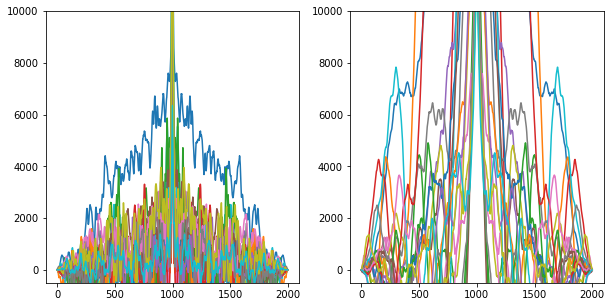

In [247]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
for i in range(dim): plt.plot(autocorrelation(states_cdcs[:, i]))
plt.ylim([-500, 10000])

plt.subplot(122)
for i in range(dim): plt.plot(autocorrelation(states_vanilla[:, i]))
plt.ylim([-500, 10000])

plt.show()

In [248]:
tf.reduce_sum(tfp.mcmc.effective_sample_size(states_cdcs))

<tf.Tensor: shape=(), dtype=float32, numpy=1035.5607>

In [249]:
tf.reduce_sum(tfp.mcmc.effective_sample_size(states_vanilla))

<tf.Tensor: shape=(), dtype=float32, numpy=182.54672>

## Sampling from a mixture of two Gaussians

In [282]:
def mog_log_prob(x, mean1, mean2, cov, mix_prob):
    
    diff1 = x - mean1
    prec_diff1 = tf.linalg.solve(cov, diff1)
    quad1 = - 0.5 * tf.reduce_sum(diff1 * prec_diff1, axis=0)
    
    diff2 = x - mean2
    prec_diff2 = tf.linalg.solve(cov, diff2)
    quad2 = - 0.5 * tf.reduce_sum(diff2 * prec_diff2, axis=0)
    
    result = tf.math.log(mix_prob * tf.math.exp(quad1) + (1 - mix_prob) * tf.exp(quad2))
    
    return result

def mog_log_prob_grad(x, mean1, mean2, cov, mix_prob):
    
    with tf.GradientTape() as tape:
        
        tape.watch(x)
        
        log_prob = mog_log_prob(x, mean1, mean2, cov, mix_prob)
        
    gradients = tape.gradient(log_prob, x)
    
    return log_prob, gradients

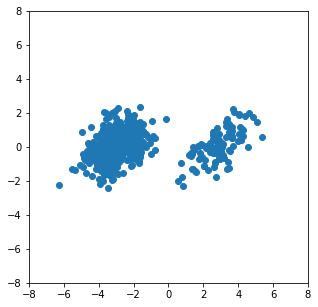

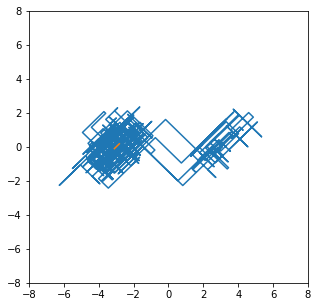

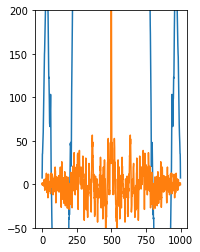

In [365]:
num_results = 500
init_state = tf.transpose(tf.convert_to_tensor([[-3.1, -0.1]]))
mean1 = tf.transpose(tf.convert_to_tensor([[-3.0, 0.0]]))
mean2 = tf.transpose(tf.convert_to_tensor([[3.0, 0.0]]))
cov = tf.convert_to_tensor([[1.0, 0.5],
                            [0.5, 1.0]])
mix_prob = 0.5

log_prob = lambda x : mog_log_prob(x, mean1, mean2, cov, mix_prob)

states_vanilla = tfp.mcmc.sample_chain(num_results=num_results,
                                       current_state=init_state,
                                       kernel=tfp.mcmc.SliceSampler(target_log_prob_fn=log_prob,
                                                                    step_size=1.0,
                                                                    max_doublings=5),
                                       num_burnin_steps=0,
                                       num_steps_between_results=0,
                                       trace_fn=None)

states_ = np.array(states_vanilla)[:, :, 0]

plt.figure(figsize=(5, 5))
plt.scatter(states_[:, 0], states_[:, 1])
plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(states_[:, 0], states_[:, 1])
plt.plot([states_[0, 0], init_state[0]], [states_[0, 1], init_state[1]])

plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.show()

plt.subplot(122)
corr3 = correlate(states_[:, 0], states_[:, 0])
corr3 = corr3 - np.mean(states_[:, 0]) ** 2
plt.plot(corr3)
corr4 = correlate(states_[:, 1], states_[:, 1])
corr4 = corr4 - np.mean(states_[:, 1]) ** 2
plt.plot(corr4)
plt.ylim([-50, 200])

plt.show()

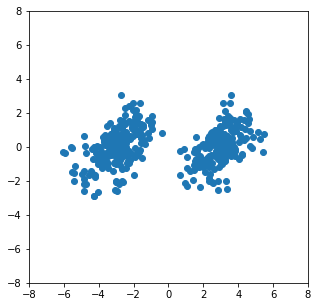

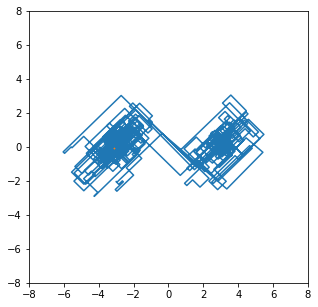

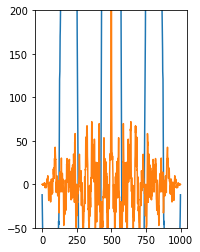

In [366]:
num_results = 500
init_state = tf.transpose(tf.convert_to_tensor([[-3.1, -0.1]]))
mean1 = tf.transpose(tf.convert_to_tensor([[-3.0, 0.0]]))
mean2 = tf.transpose(tf.convert_to_tensor([[3.0, 0.0]]))
cov = tf.convert_to_tensor([[1.0, 0.5],
                            [0.5, 1.0]])

mix_prob = 0.5

log_prob = lambda x : mog_log_prob_grad(x, mean1, mean2, cov, mix_prob)

states_cdcs = tfp.mcmc.sample_chain(num_results=num_results,
                                    current_state=init_state,
                                    kernel=cgcs_kernel(log_prob, reset_every=1),
                                    num_burnin_steps=0,
                                    num_steps_between_results=0,
                                    trace_fn=None)

states_ = np.array(states_cdcs)[:, :, 0]

plt.figure(figsize=(5, 5))
plt.scatter(states_[:, 0], states_[:, 1])
plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(states_[:, 0], states_[:, 1])
plt.plot([states_[0, 0], init_state[0]], [states_[0, 1], init_state[1]])

plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.show()

plt.subplot(122)
corr3 = correlate(states_[:, 0], states_[:, 0])
corr3 = corr3 - np.mean(states_[:, 0]) ** 2
plt.plot(corr3)
corr4 = correlate(states_[:, 1], states_[:, 1])
corr4 = corr4 - np.mean(states_[:, 1]) ** 2
plt.plot(corr4)
plt.ylim([-50, 200])

plt.show()

In [367]:
tf.reduce_sum(tfp.mcmc.effective_sample_size(states_cdcs))

<tf.Tensor: shape=(), dtype=float32, numpy=130.87683>

In [368]:
tf.reduce_sum(tfp.mcmc.effective_sample_size(states_vanilla))

<tf.Tensor: shape=(), dtype=float32, numpy=138.62498>

# Notes

- CDCS can fail if $d$ is zero.
- Finite differences must be handled with care.
- Handle the case when $A$ is zero, or close to zero.
- Think about ergodicity, interleave with random choices of $d$.